<a href="https://colab.research.google.com/github/tumanov-a/hello-world/blob/main/nlp_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [120]:
import numpy as np # linear algebra
import seaborn as sns
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import re
import os
import ktrain

from ktrain import text
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences

%matplotlib inline

os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID';
os.environ['CUDA_VISIBLE_DEVICES']='0';
plt.style.use('ggplot')

In [2]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 137kB/s 
     |████████████████████████████████| 983kB 54.3MB/s 
     |████████████████████████████████| 266kB 50.3MB/s 
     |████████████████████████████████| 1.3MB 50.9MB/s 
     |████████████████████████████████| 1.1MB 56.2MB/s 
     |████████████████████████████████| 471kB 38.9MB/s 
     |████████████████████████████████| 2.9MB 49.5MB/s 
     |████████████████████████████████| 890kB 53.1MB/s 
  Created wheel for ktrain: filename=ktrain-0.25.1-cp36-none-any.whl size=25276126 sha256=523a05730e99115668e95eef033a2661540c3c089fa7422bcae2c483341004f1
  Stored in directory: /root/.cache/pip/wheels/4c/af/2a/3b4aa379166bc910a4132ecb83f795c854b2a4293f83f0b736
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=7f42e590869d146c1267de560988f0aef9bcce263e2e984fd041e6ea425707f7
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
  Created wheel for syn

In [32]:
df_train = pd.read_csv('/content/train.csv', index_col='id')
df_test = pd.read_csv('/content/test.csv', index_col='id')

df_train = df_train[['text', 'target']]
df_test = df_test[['text']]

df_train['text'] = df_train['text'].apply(lambda x: ' '.join([seq for seq in x.split('http') if 't.co' not in seq]))
df_train.drop_duplicates(['text'], inplace=True)
df_test['text'] = df_test['text'].apply(lambda x: ' '.join([seq for seq in x.split('http') if 't.co' not in seq]))

REPLACE_PAT = re.compile('([#@][A-z]+)|(\d+)|(\_)|(\\[x])|(û)')

df_train['text'] = df_train['text'].apply(lambda x: REPLACE_PAT.sub('', x))
df_test['text'] = df_test['text'].apply(lambda x: REPLACE_PAT.sub('', x))

X_train = np.array(df_train.text)
y_train = np.array(df_train.target)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [40]:
(x_train, y_train), (x_val, y_val), preproc = text.texts_from_array(X_train, y_train, x_test=X_val, y_test=y_val, preprocess_mode='bert', random_state=42, class_names=['not disaster', 'disaster'])

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:605: UserWarning: class_names implies classification but targets array contains float(s) instead of integers or strings
  warnings.warn('class_names implies classification but targets array contains float(s) instead of integers or strings')


task: text classification


In [41]:
model = text.text_classifier('bert', (x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 400
done.


In [46]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), val_data=(x_val, y_val), batch_size=12)

In [51]:
learner.lr_find(max_epochs=5)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
456/456 [==============================] - 639s 1s/step - loss: 0.6519 - accuracy: 0.6041
Epoch 2/5
456/456 [==============================] - 641s 1s/step - loss: 0.4607 - accuracy: 0.7983
Epoch 3/5
456/456 [==============================] - 640s 1s/step - loss: 0.7211 - accuracy: 0.6004
Epoch 4/5
456/456 [==============================] - 640s 1s/step - loss: 4.2646 - accuracy: 0.5285


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


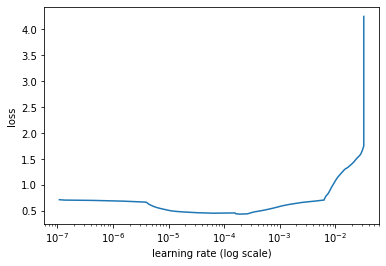

In [55]:
learner.lr_plot()

In [59]:
learner.fit_onecycle(1e-4, 5)



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/5
456/456 [==============================] - 680s 1s/step - loss: 0.4671 - accuracy: 0.7906 - val_loss: 0.4799 - val_accuracy: 0.7855
Epoch 2/5
456/456 [==============================] - 678s 1s/step - loss: 0.3722 - accuracy: 0.8497 - val_loss: 0.4433 - val_accuracy: 0.7994
Epoch 3/5
456/456 [==============================] - 677s 1s/step - loss: 0.2817 - accuracy: 0.8949 - val_loss: 0.5378 - val_accuracy: 0.8031
Epoch 4/5
456/456 [==============================] - 676s 1s/step - loss: 0.1509 - accuracy: 0.9511 - val_loss: 0.6263 - val_accuracy: 0.7987
Epoch 5/5
456/456 [==============================] - 676s 1s/step - loss: 0.0506 - accuracy: 0.9826 - val_loss: 0.7264 - val_accuracy: 0.8192


In [107]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [104]:
learner.view_top_losses(n=1)

----------
id:256 | loss:8.83 | true:1 | pred:0)

[  101  5661  2024  3972 22890  2094  2007  1999  6767 23522  1012  2191
  6737  3233  2041  2007  6120  2030  4338  1998  2009  1005  1055  3497
  2000  4125  2000  1996  2327  1997  1056  1041  3477  1005  8632  4160
   102     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
 

In [106]:
X_val[256]

"Businesses are deluged with invoices. Make yours stand out with colour or shape and it's likely to rise to the top of t e pay' pileq"

In [109]:
predicted_labels = predictor.predict(df_test.text.tolist())

In [110]:
df_test['target'] = predicted_labels

In [111]:
df_test['target'] = df_test['target'].map({'disaster': 1, 'not disaster': 0})

In [112]:
df_test

,text,target
id,,
0,Just happened a terrible car crash,1
2,"Heard about #earthquake is different cities, s...",1
3,"there is a forest fire at spot pond, geese are...",1
9,Apocalypse lighting. #Spokane #wildfires,1
11,Typhoon Soudelor kills 28 in China and Taiwan,1
...,...,...
10861,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
10865,Storm in RI worse than last hurricane. My city...,1
10868,Green Line derailment in Chicago,1


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_val, lr.predict(X_val)))

In [113]:
df_test[['target']].to_csv('submission_bert.csv')

In [ ]:
# X_train = df_train.text.tolist()

# tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(X_train, 10000, max_subword_length=5)

# for i in range(len(X_train)):
#     X_train[i] = tokenizer.encode(X_train[i])

# sentences_padded = pad_sequences(X_train, maxlen=100, padding='post', truncating='post')

# X_train = np.array(sentences_padded)
# y_train = np.array(df_train.target)

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [9]:
df_train = pd.read_csv('/content/train.csv', index_col='id')
df_test = pd.read_csv('/content/test.csv', index_col='id')

df_train = df_train[['text', 'target']]
df_test = df_test[['text']]

print(df_train.shape)
df_train['text'] = df_train['text'].apply(lambda x: ' '.join([seq for seq in x.split('http') if 't.co' not in seq]))
df_train.drop_duplicates(['text'], inplace=True)
print(df_train.shape)

df_test['text'] = df_test['text'].apply(lambda x: ' '.join([seq for seq in x.split('http') if 't.co' not in seq]))

REPLACE_PAT = re.compile('([#@][A-z]+)|(\d+)|(\_)|(\\[x])|(û)')

df_train['text'] = df_train['text'].apply(lambda x: REPLACE_PAT.sub('', x))
df_test['text'] = df_test['text'].apply(lambda x: REPLACE_PAT.sub('', x))


X_train = np.array(df_train.text)
y_train = np.array(df_train.target)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

(7613, 2)
(6829, 2)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english', binary=True)
X_train = vect.fit_transform(X_train)
X_val = vect.transform(X_val)

from sklearn.svm import LinearSVC

linsvc = LinearSVC(C=0.1)
linsvc.fit(X_train, y_train)

linsvc.score(X_val, y_val)

0.787701317715959

In [ ]:
feature_score = dict(np.c_[vect.get_feature_names(), linsvc.coef_[0]])

In [ ]:
sorted(feature_score.items(), key=lambda x: x[1], reverse=True)

[('wildfire', '0.7481878475324311'),
 ('massacre', '0.7421034652569525'),
 ('fires', '0.7246066607042351'),
 ('hiroshima', '0.7188616317485093'),
 ('typhoon', '0.703600967354743'),
 ('casualties', '0.6913729192922792'),
 ('drought', '0.6834382511899615'),
 ('bombing', '0.6604764523201131'),
 ('storm', '0.660210983687677'),
 ('hailstorm', '0.6585251027601124'),
 ('earthquake', '0.6489252331708177'),
 ('floods', '0.6448567862792054'),
 ('evacuated', '0.6170892073806369'),
 ('derailment', '0.5945272826766861'),
 ('outbreak', '0.5764185679130344'),
 ('california', '0.5688595718947165'),
 ('shot', '0.5499984080133828'),
 ('deaths', '0.5456976022253816'),
 ('train', '0.5436109818417643'),
 ('scene', '0.5432580025600108'),
 ('atomic', '0.5393284241151806'),
 ('distance', '0.520770883558662'),
 ('riots', '0.5185442264646568'),
 ('mass', '0.5066635793700754'),
 ('volcano', '0.5065324929068282'),
 ('japan', '0.5020238357594952'),
 ('evacuation', '0.5006208122992395'),
 ('myanmar', '0.49852935138

In [ ]:
print(sorted(list(vect.vocabulary_)))

['aa', 'aa ayyo', 'aa batteries', 'aa mgm', 'aa near', 'aaaa', 'aaaa ok', 'aaaaaaallll', 'aaaaaaallll ûªm', 'aaaaaand', 'aaaaaand thunder', 'aaarrrgghhh', 'aal', 'aan', 'aan den', 'aannnnd', 'aannnnd reddit', 'aar', 'aar ambulance', 'aashiqui', 'aashiqui actress', 'aba', 'aba woman', 'abandon', 'abandon plans', 'abandon ship', 'abandon west', 'abandoned', 'abandoned aircraft', 'abandoned cabin', 'abandoned cocker', 'abandoned lrt', 'abandoning', 'abandoning deal', 'abbandoned', 'abbandoned sinking', 'abbott', 'abbott amp', 'abbott lnp', 'abbswinston', 'abbswinston demolish', 'abbswinston kidnapped', 'abc', 'abc news', 'abc onlin', 'abc online', 'abc onlinea', 'abc onlinemh', 'abc trauma', 'abcnews', 'abcnews obama', 'abe', 'abe deluged', 'abe government', 'abe pledged', 'aberdeen', 'aberdeen tomorrow', 'aberystwyth', 'aberystwyth shrewsbury', 'abia', 'abia inec', 'ability', 'ability annihilate', 'ability massacre', 'ability offer', 'abject', 'abject desolation', 'ablaze', 'ablaze aba',

In [ ]:
df_train['text'].tolist()

['Our Deeds are the Reason of this  May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 ', people receive  evacuation orders in California ',
 'Just got sent this photo from Ruby  as smoke from  pours into a school ',
 ' Update => California Hwy.  closed in both directions due to Lake County fire -  ',
 '  Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area...",
 'Three people died from the heat wave so far',
 'Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK ',
 "      or  days. I've lost count ",
 ' in Bago Myanmar  arrived Bago',
 'Da

In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

MAX_FEATURES = 20000

txt_vector = TextVectorization(max_tokens=MAX_FEATURES, output_mode='int')

data_for_vec = dataset_train.map(lambda x, y: x)

txt_vector.adapt(data_for_vec)

vocab_size = len(txt_vector.get_vocabulary())
reverse_word_index = txt_vector.get_vocabulary()

In [ ]:
print(sorted(reverse_word_index))

['', '[UNK]', 'a', 'aa', 'aaaa', 'aaaaaaallll', 'aaaaaand', 'aaarrrgghhh', 'aal', 'aampb', 'aampw', 'aan', 'aannnnd', 'aar', 'aashiqui', 'aba', 'abandon', 'abandoned', 'abandoning', 'abbandoned', 'abbott', 'abbswinston', 'abc', 'abcnews', 'abcs', 'abe', 'aberdeen', 'aberystwythshrewsbury', 'abes', 'abia', 'ability', 'abject', 'ablaze', 'able', 'aboard', 'abomb', 'abombed', 'abomination', 'abortion', 'abortions', 'about', 'above', 'abs', 'absence', 'absolute', 'absolutely', 'abstract', 'absurd', 'absurdly', 'abuse', 'abused', 'abusing', 'ac', 'academia', 'acc', 'accept', 'accepte', 'accepts', 'access', 'accident', 'accidentally', 'accidently', 'accidents', 'accidents\x89Ûª', 'accidentwho', 'accompanying', 'according', 'accordingly', 'account', 'accounts', 'accuracy', 'accused', 'accuses', 'accustomed', 'acdcd', 'acdelco', 'ace', 'acesse', 'achieve', 'achievement', 'achieving', 'achimota', 'aching', 'acid', 'acids\x89Ûª', 'acne', 'acoustic', 'acquiesce', 'acquire', 'acquired', 'acquisiti

In [ ]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return txt_vector(text), label

In [ ]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

BATCH_SIZE = 32

dataset_train = dataset_train.shuffle(X_train.shape[0]).batch(BATCH_SIZE).cache().prefetch(1)
dataset_val = dataset_val.batch(BATCH_SIZE).cache().prefetch(1)

dataset_train = dataset_train.map(vectorize_text)
dataset_val = dataset_val.map(vectorize_text)

In [ ]:
#best_score

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(
    min_delta=0.000,
    patience=5,
    restore_best_weights=True
)

model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    #tf.keras.layers.Dropout(0.2),
    #tf.keras.layers.Conv1D(16, 5, activation='relu'),
    #tf.keras.layers.GlobalMaxPooling1D(),
    #tf.keras.layers.GlobalAveragePooling1D(),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(
    min_delta=0.000,
    patience=5,
    restore_best_weights=True
)

model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 16),
    tf.keras.layers.GlobalMaxPooling1D(), 
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = EarlyStopping(
    min_delta=0.000,
    patience=5,
    restore_best_weights=True
)

model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
epochs = 100

history = model.fit(
    dataset_train,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=dataset_val

)

Epoch 1/100
193/193 [==============================] - 12s 60ms/step - loss: 0.7417 - accuracy: 0.5882 - val_loss: 0.7116 - val_accuracy: 0.6047
Epoch 2/100
193/193 [==============================] - 10s 54ms/step - loss: 0.6979 - accuracy: 0.5882 - val_loss: 0.6948 - val_accuracy: 0.6047
Epoch 3/100
193/193 [==============================] - 11s 56ms/step - loss: 0.6940 - accuracy: 0.5882 - val_loss: 0.6937 - val_accuracy: 0.6047
Epoch 4/100
193/193 [==============================] - 11s 56ms/step - loss: 0.6935 - accuracy: 0.5882 - val_loss: 0.6934 - val_accuracy: 0.6047
Epoch 5/100
193/193 [==============================] - 11s 56ms/step - loss: 0.6933 - accuracy: 0.5882 - val_loss: 0.6933 - val_accuracy: 0.6047
Epoch 6/100
 10/193 [>.............................] - ETA: 13s - loss: 0.6933 - accuracy: 0.6094

KeyboardInterrupt: 

In [ ]:
history = model.history

plt.figure(figsize=(20,8))

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

plt.show()

model.evaluate(dataset_val, batch_size=BATCH_SIZE)

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

In [ ]:
import io

outv = io.open('vecs.tsv', 'w', encoding='utf-8')
outm = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    outm.write(word + '\n')
    outv.write(''.join([str(x) for x in embeddings]) + '\n')
outv.close()
outm.close()

In [ ]:
outv.to_csv('outv.tsv')

In [ ]:
X_test = np.array(df_test)
#dataset_test = tf.data.Dataset.from_tensor_slices((X_test)).map(txt_vector)

In [ ]:
export_model = tf.keras.Sequential([
    txt_vector,
    model,
    #tf.keras.layers.Activation('sigmoid')
])

In [ ]:
export_model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=False),
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
df_test.head(15)

In [ ]:
predictions = export_model.predict(df_test['text'])

In [ ]:
df_test['target'] = predictions

In [ ]:
df_test['target'] = df_test['target'].apply(lambda x: 0 if x < 0.5 else 1)

In [ ]:
df_test[['target']].value_counts()

In [ ]:
df_test[['target']].to_csv('submission_after_del_leaks_emb.csv')

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_val, lr.predict(X_val)))

In [114]:
scores = [0.78915, 0.79865, 0.79650, 0.79282, 0.78945, 0.79987, 0.78884, 0.78945, 0.81826]
ind = list(range(len(scores)))

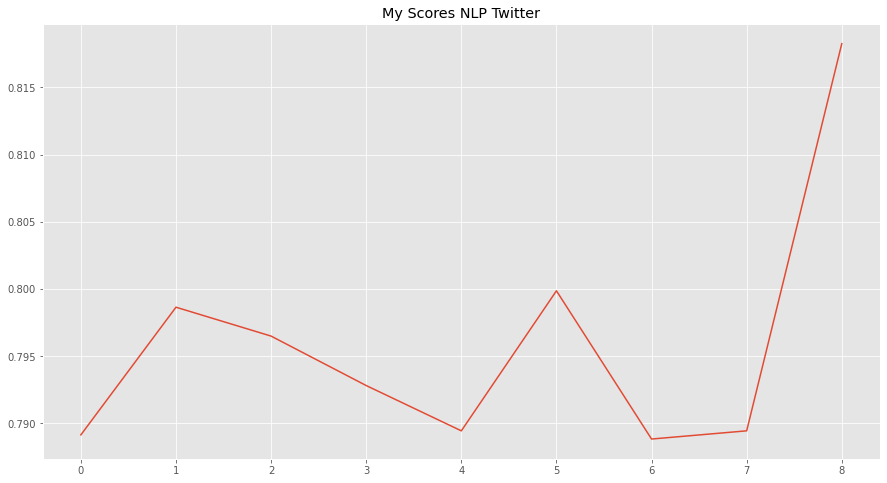

In [124]:
plt.figure(figsize=[15,8])
sns.lineplot(ind, scores)
plt.title('My Scores NLP Twitter')
plt.show()

In [118]:
sns.lineplot?